# IOD_seasonality: Seasonal Variability of SST Anomalies in the Tropical Indian Ocean¶
Computes the ratio of austral autumn (Mar-May) to spring (Sep-Nov) standard deviation of sea surface temperature anomalies (SSTA) in the Dipole Mode Index (gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern Indian Ocean (90E-110E and 10S-0N). This metric evaluates the seasonality of IOD variability.

# Datasets Used for Seasonality Comparison
The following reference datasets are employed to evaluate the IOD-related SST patterns in model simulations:
- **HadISST** (1870–2018): A long-term SST and sea ice dataset combining ship and buoy observations with historical data reconstruction.

Additional datasets include:
- **ERA-Interim** (1979–2018): A widely used reanalysis dataset offering high-resolution estimates of atmospheric and surface variables with robust data assimilation techniques.
- **ERSSTv5** (1854–2018): A globally gridded dataset of historical SSTs derived from in-situ measurements and optimised for climate monitoring and iod studies.

## Dask Cluster

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40415 instead
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysi

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40415/status,
Dashboard: /proxy/40415/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40211,Workers: 0
Dashboard: /proxy/40415/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44631,Total threads: 1
Dashboard: /proxy/44837/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:46449,


In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftof', mip="Ofx")
    dataset.add_supplementary(short_name="areacello", mip="Ofx")

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/esmvalcore/config/_config.py:59: ESMValCoreDeprecationWarning: Usage of extra facets located in ~/.esmvaltool/extra_facets has been deprecated in ESMValCore version 2.13.0 and is scheduled for removal in version 2.15.0. Please use the configuration option `extra_facets` instead (see https://github.com/ESMValGroup/ESMValCore/pull/2747 for details). To silent this warning and ignore deprecated extra facets, set the environment variable ESMVALTOOL_USE_NEW_EXTRA_FACETS_CONFIG=1.
  warn_if_old_extra_facets_exist()
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/esmvalcore/config/_config.py:59: ESMValCoreDeprecationWarning: Usage of extra facets located in ~/.esmvaltool/extra_facets has been deprecated in ESMValCore version 2.13.0 and is scheduled for removal in version 2.15.0. Please use the configuration option `extra_facets` instead (see https://github.com/ESMValGroup/

In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [7]:
def sst_austral(cube, season):
    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}

    cube = convert_units(cube, units="degC")

    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')

    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')
    
    cube_west = extract_season(cube_west, season)
    cube_east = extract_season(cube_east, season)

    #dmi = iod_west - iod_east
    cube_dmi = cube_west - cube_east
    # compute temporal standard deviation
    cube = climate_statistics(cube_dmi, operator="std_dev", period="full")
    return cube

def sst_std(cube):
    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}

    cube = convert_units(cube, units="degC")
    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')

    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')
    
    cube_dmi = cube_west - cube_east
    cube = climate_statistics(cube_dmi, operator="std_dev", period="monthly") #monthly to plot months
    return cube
    
def sst_std_3(cube):
    iod_trop = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}

    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **iod_trop)
    cube = anomalies(cube,period='monthly')
    cube = meridional_statistics(cube, 'mean')
    cube = climate_statistics(cube, operator="std_dev", period="monthly") #monthly
    return cube

In [8]:
model_datasets_prep = {name: sst_austral(dataset, 'MAM') for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: sst_austral(dataset,'MAM') for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: sst_austral(dataset, 'SON') for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: sst_austral(dataset,'SON') for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(

# Diagnostic Level 1
The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

In [9]:
model_ = {'australautumn':model_datasets_prep["ACCESS-ESM1-5"], 'australspring':model_datasets_prep2["ACCESS-ESM1-5"]}

obs_ = {'australautumn':obs_datasets_prep["HadISST"], 'australspring':obs_datasets_prep2["HadISST"]}

mod_seas = model_['australautumn'].data.item()/model_['australspring'].data.item()
obs_seas = obs_['australautumn'].data.item()/obs_['australspring'].data.item()

# abs((mod_seas-obs_seas)/obs_seas)*100, mod_seas, obs_seas

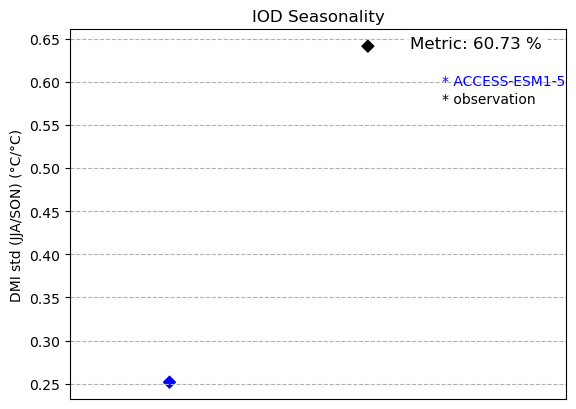

In [10]:
ssta_std = [mod_seas, obs_seas]
plt.scatter(range(len(ssta_std)), ssta_std, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)
plt.xticks([])

plt.ylabel('DMI std (MAM/SON) (°C/°C)')
plt.grid(linestyle='--', axis='y')
plt.title('IOD Seasonality')

metricval = abs((mod_seas-obs_seas)/obs_seas)*100

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
plt.show()

Figure 1: Ratio of winter to spring standard deviation of the Dipole Mode Index, illustrating the seasonal timing of SSTA. The model typically exhibits weaker variability than observed. Black markers represent the reference data, while blue markers represent the model output. The derived metric is the absolute relative difference, calculated as: ( $\frac{abs(model - ref)}{ref} \times 100$ ).

# Diagnostic Level 2
The second level shows the mean annual structure of the IOD amplitude: the 12 months standard deviation of the anomalies.

In [11]:
model_data_prep = {name: sst_std(dataset) for name, dataset in model_datasets.items()}
obs_data_prep = {name: sst_std(dataset) for name, dataset in obs_datasets.items()}

data_prep_2 = [model_data_prep["ACCESS-ESM1-5"], obs_data_prep["HadISST"]]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(

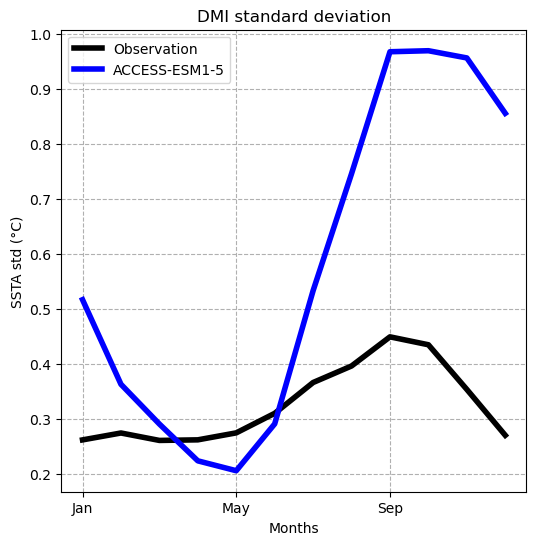

In [12]:

# Create the plot
plt.figure(figsize=(6, 6))

# Plot observation data in black
qplt.plot(data_prep_2[1], color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(data_prep_2[0], color='blue', label='ACCESS-ESM1-5', linewidth=4)

# Define x-axis labels
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = ['Jan', 'May', 'Sep']
plt.xticks(range(1,13,4),labels=months)
# Set the x and y axis labels
plt.xlabel('Months')
plt.ylabel('SSTA std (°C)')
plt.title('DMI standard deviation')
plt.grid(linestyle='--'); plt.legend()

Figure 2: Mean annual structure of the standard deviation of the DMI, illustrating the seasonal variability. The model typically shows too strong variability in winter and spring. The black curve represents the reference data, while the blue curve corresponds to the model output.

# Diagnostic Level 3

The third level shows the spatio-mean annual structure of the tropical Indian Ocean amplitude: the Hovmöller of the standard deviation of anomalies in the equatorial Indian Ocean.

In [13]:
model_data_prep3 = {name: sst_std_3(dataset) for name, dataset in model_datasets.items()}
obs_data_prep3 = {name: sst_std_3(dataset) for name, dataset in obs_datasets.items()}

data_prep_3 = {**model_data_prep3, "HadISST":obs_data_prep3["HadISST"]}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=

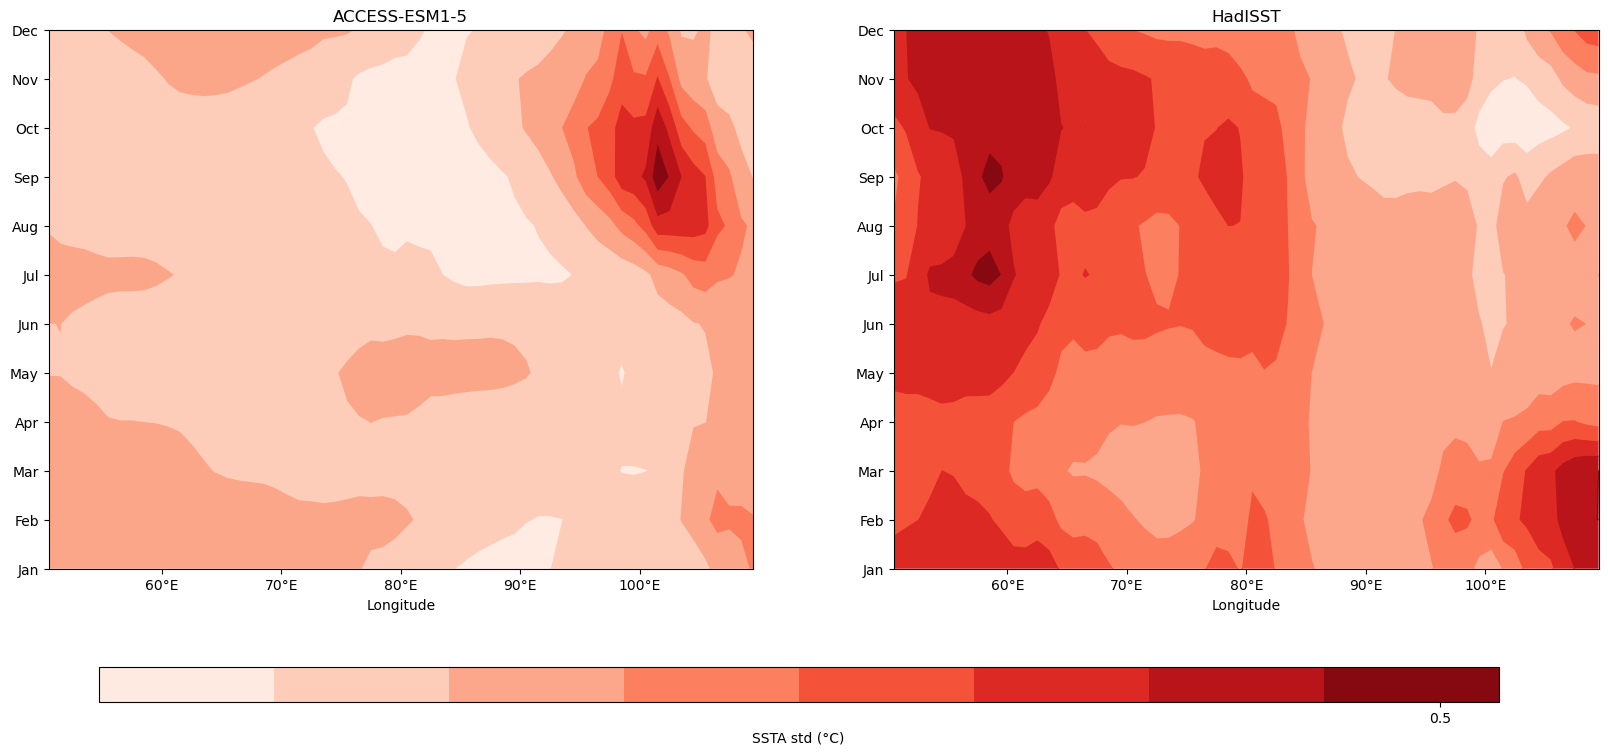

In [14]:
import iris.plot as iplt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

# Function to format longitude labels
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

fig = plt.figure(figsize=(20, 7))
i =121

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for label, cube in data_prep_3.items():
    
    ax1 = plt.subplot(i)
    c1 = iplt.contourf(cube, cmap='Reds')
    ax1.set_yticks(range(1,13), labels=months)
    ax1.set_title(label)
    ax1.set_xlabel("Longitude")
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,-0.08,0.7,0.05])
cbar = fig.colorbar(c1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,2,0.5))
cbar.set_label('SSTA std (°C)')

Figure 3: Spatio-mean annual structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Indian Ocean (averaged between 10°S and 10°N). The left map displays the model output, while the right map shows the reference data.